# Usage

`decoupler` provides various statistical methods to infer enrichment scores
from omics data using prior knowledge {cite:p}`decoupler`.

It is a package from the scverse ecosystem {cite:p}`scverse`,
designed for easy interoperability with `anndata` and `scanpy` {cite:p}`scanpy`.

Enrichment analysis tests whether a specific set of omics features is
"overrepresented" or "coordinated" in the measured data compared to a
background distribution.
These sets are predefined based on existing biological knowledge and
may vary depending on the omics technology used.

Enrichment analysis can be performed at two distinct resolutions:

1) Observation level: Feature set enrichment scores are computed
   individually for each observation or sample within the dataset.
   This is useful for characterizing continous processes that cannot
   be easily splitted into groups.
3) Contrast level: When the dataset includes defined groups,
   differential testing statistics can be derived between groups
   and subsequently used to compute a final vector of feature
   set enrichment scores.

This notebook provides a brief demonstration of inferring enrichment
scores at the observation level using a toy dataset.
For more detailed tutorials, refer to the other vignettes.

<div class="alert alert-info">
    
**Note**

In Jupyter Notebooks and JupyterLab, documentation for a Python function can
be accessed by pressing `SHIFT + TAB` (twice to expand) or by typing `?<function_name>`.

</div>

## Loading Packages

<div class="alert alert-info">
    
**Note**

The first time decoupler is run in an environment,
execution may be slow due to Numba compiling its source code.
Subsequent runs are faster, as the compiled code is cached.

</div>

In [1]:
import scanpy as sc
import decoupler as dc

sc.set_figure_params(figsize=(3.5, 3.5), frameon=False)

## Loading The Dataset

In [2]:
adata, net = dc.ds.toy()

The obtained {class}`anndata.AnnData` consist of log-normalized integer transcript counts for 30 cells
with measurements for 20 genes.

In [3]:
adata

AnnData object with n_obs × n_vars = 30 × 20
    obs: 'group', 'sample'

Cells are belong to two distinct groups, "A" and "B", which exhibit differences in gene expression.

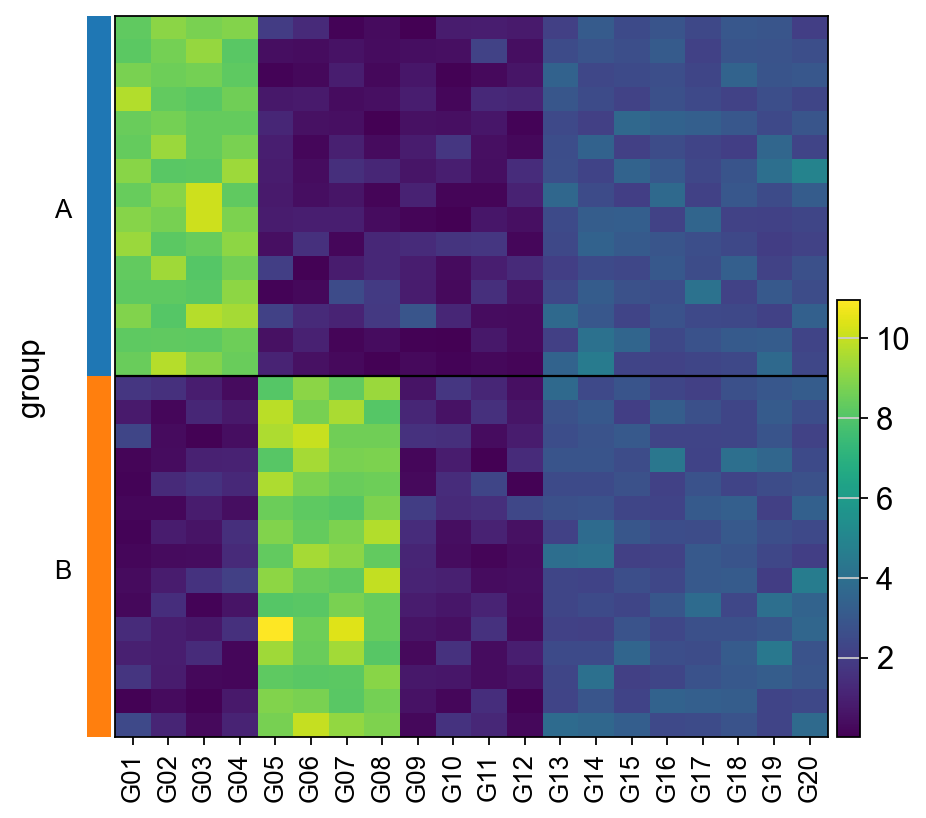

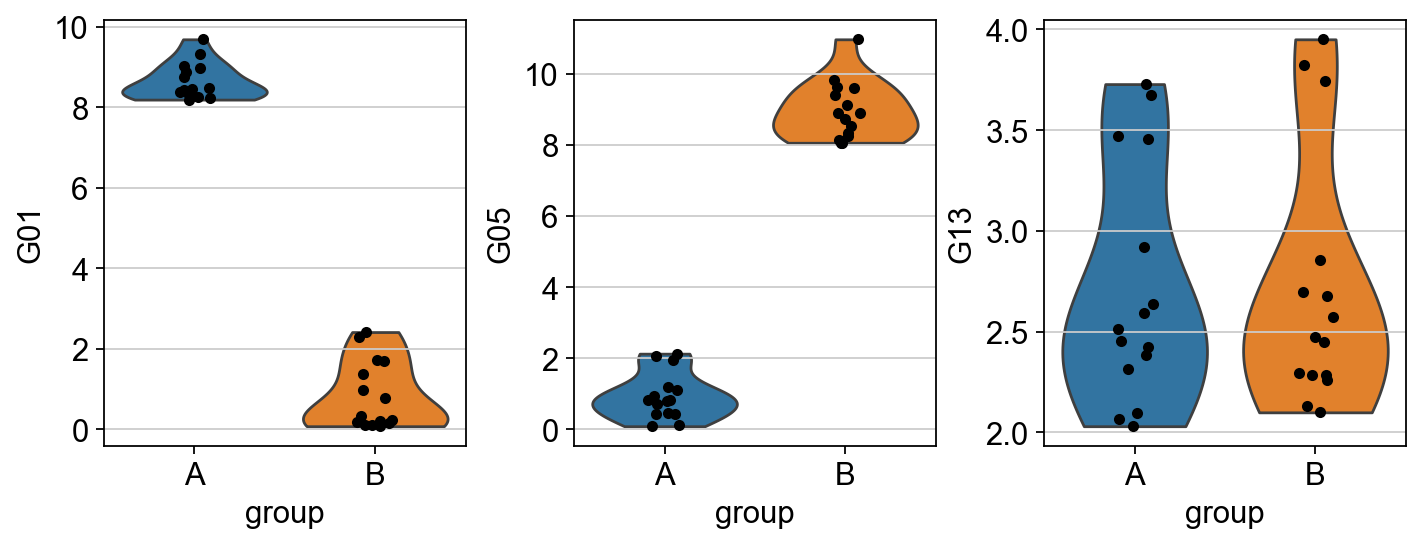

In [4]:
sc.pl.heatmap(
    adata=adata,
    groupby="group",
    var_names=adata.var_names,
)
sc.pl.violin(adata, groupby="group", keys=["G01", "G05", "G13"], size=5)

Some genes are more expressed in group A (like G01), others in group B (like G05) and
others there is no difference (like G13). Ideally, these differences in gene
expression programs should be captured in terms of interpretable biological entities.
In this example, this is achieved by summarizing gene expression into
transcription factor (TF) enrichment scores.


This toy dataset also includes a simple network comprising five TFs with defined
regulatory interactions, either positive or negative, with target genes (Gs).

In [5]:
net

,source,target,weight
0,T1,G01,1.0
1,T1,G02,1.0
2,T1,G03,0.7
3,T2,G04,1.0
4,T2,G06,-0.5
5,T2,G07,-3.0
6,T2,G08,-1.0
7,T3,G06,1.0
8,T3,G07,0.5
9,T3,G08,1.0


This network can also be visualized like a graph.

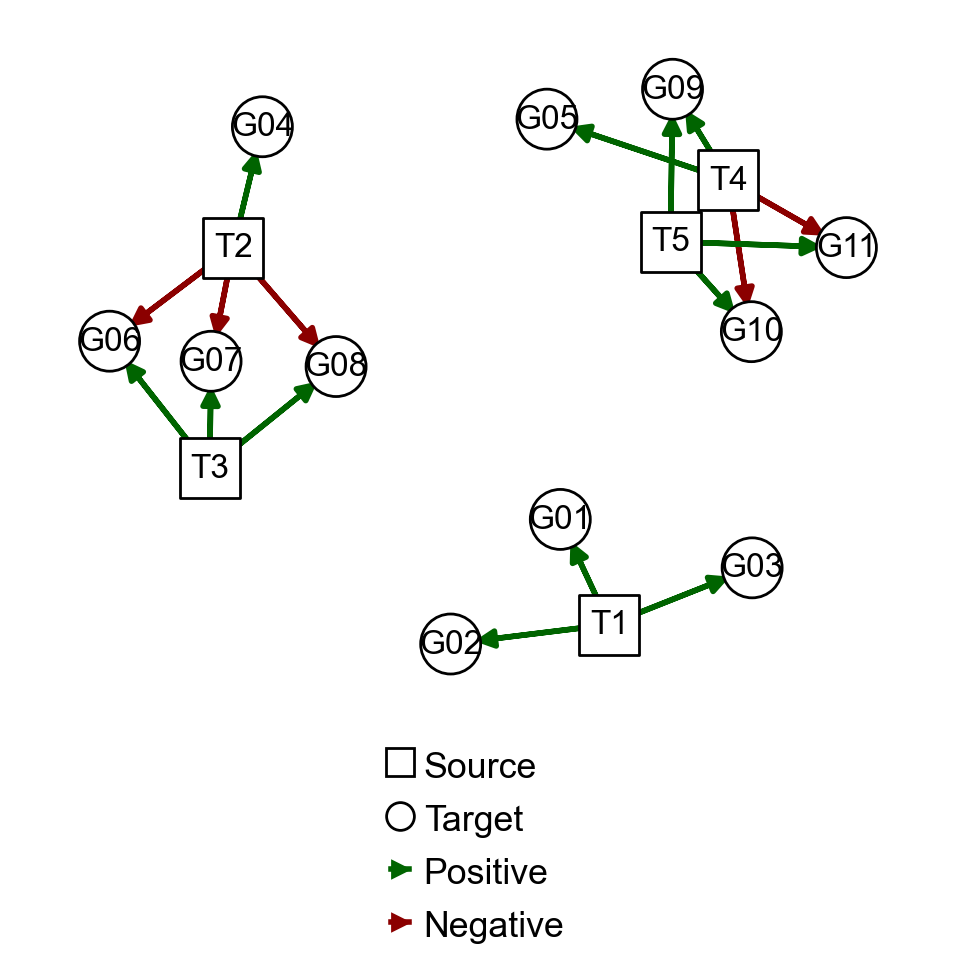

In [6]:
dc.pl.network(net, size_node=15, s_cmap="white", t_cmap="white", c_pos_w="darkgreen", c_neg_w="darkred", figsize=(5, 5))

Based on this network, and the observed pattern of gene expression,
cells in group "A" are expected to exhibit
positive activity for T1 and T2,
while cells in group "B" should show high activity for T3 and T4.
T5 is not expected to display activity in any of the cells.

## Enrichment Methods

`decoupler` contains multiple enrichment methods.

In [7]:
dc.mt.show()

,name,desc,stype,weight,test,limits,reference
0,aucell,AUCell,categorical,False,False,"(0, 1)",https://doi.org/10.1038/nmeth.4463
1,gsea,Gene Set Enrichment Analysis (GSEA),numerical,False,True,"(-inf, inf)",https://doi.org/10.1073/pnas.0506580102
2,gsva,Gene Set Variation Analysis (GSVA),numerical,False,False,"(-1, 1)",https://doi.org/10.1186/1471-2105-14-7
3,mdt,Multivariate Decision Tree (MDT),numerical,True,False,"(0, 1)",https://doi.org/10.1093/bioadv/vbac016
4,mlm,Multivariate Linear Model (MLM),numerical,True,True,"(-inf, inf)",https://doi.org/10.1093/bioadv/vbac016
5,ora,Over Representation Analysis (ORA),categorical,False,True,"(-inf, inf)",https://doi.org/10.2307/2340521
6,udt,Univariate Decision Tree (UDT),numerical,True,False,"(0, 1)",https://doi.org/10.1093/bioadv/vbac016
7,ulm,Univariate Linear Model (ULM),numerical,True,True,"(-inf, inf)",https://doi.org/10.1093/bioadv/vbac016
8,viper,Virtual Inference of Protein-activity by Enric...,numerical,True,True,"(-inf, inf)",https://doi.org/10.1038/ng.3593
9,waggr,Weighted Aggregate (WAGGR),numerical,True,True,"(-inf, inf)",https://doi.org/10.1093/bioadv/vbac016


Each method infers enrichment scores using different types of statistic
(categorical or numerical),
some incorporate feature weights,
others perform statistical testing and return p-values,
and the resulting scores may vary in their numerical range.

Consequently, methods may have specific arguments,
which can be viewed by running `?decoupler.mt.<method_name>`.

To have a unified framework, methods inside decoupler have these shared arguments:

- `data`: AnnData instance, DataFrame or tuple of [matrix, samples, features]
- `net`: Dataframe in long format. Must include `source` and `target` columns, and optionally a `weight` column:
  - `source`: feature set names, for example: TFs, pathways, cell types, etc.
  - `target`: feature names, for example: genes regulated by a TF, phosphosites modified by a Kinase, etc.
  - `weight`: (optional): strength of the source-target interaction. Will be used by enrichment methods that model feature weights.
    Can be any value between -∞ and +∞
- `tmin`: Minimum number of targets per source. Sources with fewer targets will be removed
- `raw`: Whether to use the ``.raw`` attribute of ``anndata.AnnData``
- `empty`: Whether to remove empty observations (rows) and features (columns)
- `bsize`: For large datasets in sparse format, this parameter controls how many observations are processed at once.
    Increasing this value speeds up computation but uses more memory
- `verbose`: Whether to display progress messages and additional execution details


## Running Methods

### Individual methods
As an example, the Gene Set Enrichment Analysis (`gsea`) method {cite:p}`msigdb`,
one of the most widely used statistical approaches,
will be run first.

In [8]:
dc.mt.gsea(data=adata, net=net, tmin=0)

The resulting enrichment scores can then be visualized.

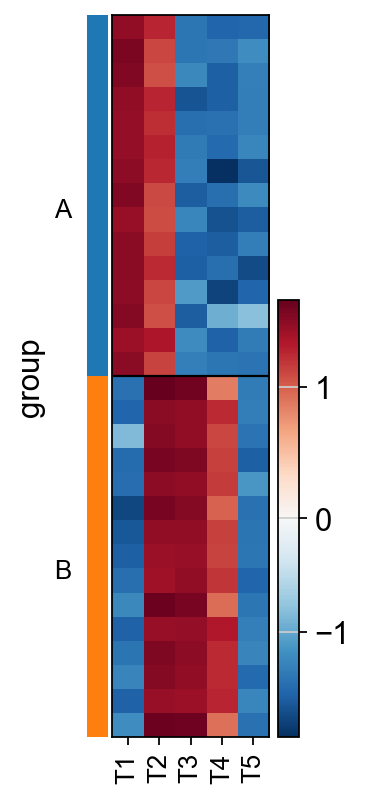

In [9]:
scores = dc.pp.get_obsm(adata, key="score_gsea")
sc.pl.heatmap(
    adata=scores,
    groupby="group",
    var_names=scores.var_names,
    cmap="RdBu_r",
    vcenter=0,
)

For TFs T1 and T3, the inferred activities effectively distinguish between the two groups of cells.
In contrast, T2 should exhibit negative enrichment scores in the "B" group due to its role as a repressor.

The misestimation of T2's activity arises from the limitation of GSEA, which does not account for weights when
inferring enrichment scores.

When weights are also available in the prior knowledge network, it is recommended to use methods that
incorporate this information to obtain more accurate estimates.
One such method is the Univariate Linear Model (ULM).

In [10]:
dc.mt.ulm(data=adata, net=net, tmin=0)

As before, score can be plotted per cell.

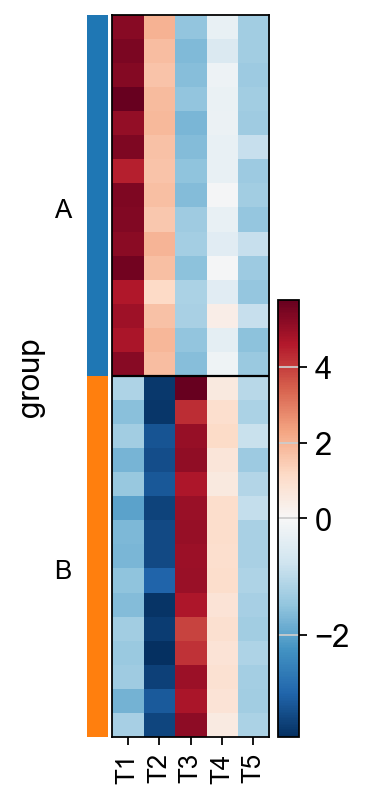

In [11]:
scores = dc.pp.get_obsm(adata, key="score_ulm")
sc.pl.heatmap(
    adata=scores,
    groupby="group",
    var_names=scores.var_names,
    cmap="RdBu_r",
    vcenter=0,
)

As `ulm` incorporates weights when estimating enrichment scores,
it accurately identifies the repressor T2 as inactive in the "B" group.

### Multiple Methods
`decoupler` enables the sequential execution of multiple methods.

For example, this line runs all available methods.

In [12]:
dc.mt.decouple(
    data=adata,
    net=net,
    methods="all",
    tmin=0,
)

It also can compute a consensus score based on the inferred activities across methods.

In [13]:
dc.mt.consensus(result=adata)

The resulting score can be visualized.

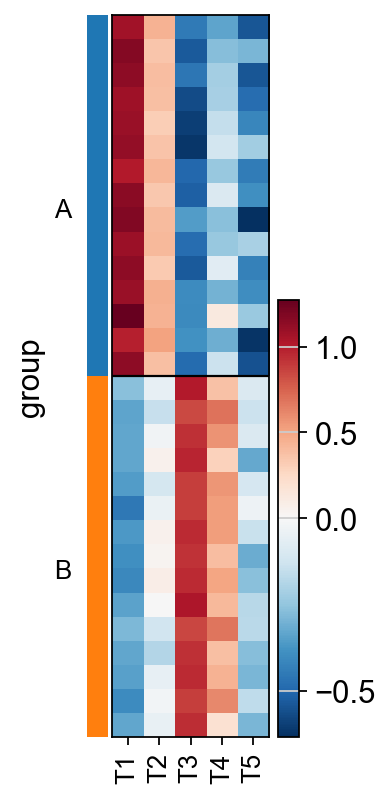

In [14]:
scores = dc.pp.get_obsm(adata, key="score_consensus")
sc.pl.heatmap(
    adata=scores,
    groupby="group",
    var_names=scores.var_names,
    cmap="RdBu_r",
    vcenter=0,
)

The consensus score correctly shows that T1 and T2 are active
in the "A" group,
while T3 and T4 are active in "B".
T5 is consistently inactive across all samples, as expected.

## Access to prior knowledge

Enrichment analysis requires omics readouts and feature sets.
However, feature set databases are distributed across multiple
sources with varying formats and access methods, making their
use more complex.

`decoupler` addresses this by leveraging
[OmniPath](https://omnipathdb.org/), a metadatabase that
integrates and processes data from numerous sources {cite:p}`omnipath`.
The `decoupler.op` module provides a unified interface
to query any database available within OmniPath.

Here is the list of available resources.

In [15]:
dc.op.show_resources()

,name,license
0,Adhesome,commercial
1,Almen2009,commercial
2,Baccin2019,academic
3,CORUM_Funcat,academic
4,CORUM_GO,academic
...,...,...
76,iTALK,academic
77,kinase.com,non_profit
78,scConnect,commercial
79,scConnect_complex,commercial


As an example, SIGNOR, a database of manually curated causal relationships
between human proteins and biological phenotypes, can be downloaded.

In [16]:
dc.op.resource("SIGNOR")

,genesymbol,pathway
,,
0,ABL1,Cell cycle: G2/M phase transition
1,ACE,Focal segmental glomerulosclerosis
2,ACTB,Axon guidance
3,ACTN1,Axon guidance
4,ACTN1,Glutamatergic synapse
...,...,...
2943,YY1,NOTCH Signaling
2944,ZAP70,T cell activation
2945,ZAP70,P38 Signaling


## Conclusion

Enrichment anaysis helps summarizing high-dimensional hard-to-interpret omics features
into interpretable terms such as TFs or pathways.

In the original manuscript of `decoupler` {cite:p}`decoupler`, we benchmarked multiple methods
and found that the univariate linear model (`ulm`) outperformed the others. Therefore, we will use
across the other vignettes.

Additionaly, `decoupler` provides streamlined access to a wide range of prior
knowledge databases via the OmniPath metadatabase.